**<font size=5>Santander-Customer-Transaction-Prediction</font>**

This is my second kaggle competition completed, where I am supposed to predict whether a Santander customer will perform a specific transaction or not.
In this kernel, I will use Convolutional Neural Network.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Conv1D, Flatten
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns

**<font size=5>Loading data</font>**

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train_copy = train.copy()
test_copy = test.copy()

**<font size=5>Data exploration</font>**

In [3]:
train_copy.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
test_copy.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [5]:
train_copy.shape

(200000, 202)

In [6]:
test_copy.shape

(200000, 201)

As we can see, there are 200 features without their real world name and 200k rows of customer record in both training and testing data, also columns of customer ID and target in training set which means whether they did the transaction.
And there are 200k rows in test data too.

In [7]:
if (train_copy.isnull().sum().sum() == 0):
    print('There is no missing value in training set')
else:
    print('There are ' + str(train_copy.isnull().sum().sum()) + ' missing values in training set')

There is no missing value in training set


In [8]:
if (test_copy.isnull().sum().sum() == 0):
    print('There is no missing value in testing set')
else:
    print('There are ' + str(train_copy.isnull().sum().sum()) + ' missing values in testing set')

There is no missing value in testing set


Great! There is no missing value in both training and testing set.

In [9]:
train_copy.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

In [10]:
test_copy.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.70445,15.265776,12.456675,13.298428,17.230598,4.299010,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.74646,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.588700,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,-22.672400,-25.811800,13.424500,-4.741300,0.670300,13.203400,0.314300,-28.90690,-11.324200,-12.699400,-2.634600,-9.940600,-5.164000,1.390600,-0.731300,12.749600,-24.536100,-6.040900,2.842500,-4.421500,-34.054800,1.309200,-8.209000,1.691100,9.776400,-16.923800,-10.466800,-0.885100,-5.368300,-14.083700,...,-8.925700,4.910600,0.106200,-6.093700,-21.514000,3.667300,1.813100,-37.176400,-5.405700,4.291500,-15.593200,-20.393600,-11.796600,-21.342800,-2.485400,2.951200,-29.838400,5.025300,-29.118500,-7.767400,-20.610600,5.346000,-28.092800,-5.476800,-17.011400,-22.467000,-2.303800,-47.306400,4.429100,-2.511500,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.91190

As shown, training data and testing data are quite similar in each feature.

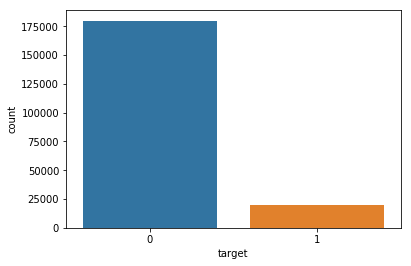

In [11]:
sns.countplot(train_copy['target'])

So there exsists imbalanced data issue with only 10% records responding 1.

To handle this problem, one can just cut '0' responding data to around numbers of positive records using 'sample()' command, but he will loss lots of information, or apply resampling mathod to create positive records.
As a result, resampling does not improve the auc much while the former way does improve but not good enough.
I am going to apply the first method.

In [12]:
random.seed(0)
train_one = train_copy[train_copy['target'] == 1]
# rows with response 0
train_zero = train_copy[train_copy['target'] == 0]
# rows equal to rows of 1
train_zero_equal = train_zero.sample(n=40000)
train = pd.concat([train_one, train_zero_equal], axis=0)
train_y = train['target'].values
train_X_column_name = train.drop(['target', 'ID_code'], axis=1).columns
train_X = train.drop(['target', 'ID_code'], axis=1).values
test_X = test_copy.drop(['ID_code'], axis=1).values
train_X_copy = train_X.copy()
test_X_copy = test_X.copy()

Until now, I have separated the training data into features and targets, and picked the features from testing data. 
And I have taken random 40000 samples from 0 responding data, after parameter tuning.

In [13]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

I just scaled the training data among features.

Let's try very basic neural network model first.

In [14]:
model = Sequential()
model.add(Dense(32, input_dim=200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


And do K fold validation 

In [15]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(train_X, train_y)):
    train_xx, valid_xx = train_X[train_idx], train_X[valid_idx]
    train_t, valid_t = train_y[train_idx], train_y[valid_idx]
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(train_xx, train_t, validation_data=(valid_xx, valid_t), epochs=10, batch_size=500)

Train on 48078 samples, validate on 12020 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
48078/48078 [==============================] - 1s 17us/sample - loss: 0.5699 - acc: 0.6971 - val_loss: 0.4643 - val_acc: 0.7822
Epoch 2/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4518 - acc: 0.7900 - val_loss: 0.4507 - val_acc: 0.7923
Epoch 3/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4408 - acc: 0.7970 - val_loss: 0.4479 - val_acc: 0.7953
Epoch 4/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4343 - acc: 0.8009 - val_loss: 0.4466 - val_acc: 0.7953
Epoch 5/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4286 - acc: 0.8044 - val_loss: 0.4459 - val_acc: 0.7959
Epoch 6/10
48078/48078 [==============================] - 0s 8us/sample - loss: 0.4238 - acc: 0.8074 - val_loss: 0.4443 - val_acc: 0.7968
Epoch 7/10
48078/48078 [==============================] - 0s 7us/sample -

Then I add one more layer and try again

In [16]:
model = Sequential()
model.add(Dense(32, input_dim=200, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(train_X, train_y)):
    train_xx, valid_xx = train_X[train_idx], train_X[valid_idx]
    train_t, valid_t = train_y[train_idx], train_y[valid_idx]
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(train_xx, train_t, validation_data=(valid_xx, valid_t), epochs=10, batch_size=500)

Train on 48078 samples, validate on 12020 samples
Epoch 1/10
48078/48078 [==============================] - 1s 16us/sample - loss: 0.5782 - acc: 0.6950 - val_loss: 0.4634 - val_acc: 0.7817
Epoch 2/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4495 - acc: 0.7932 - val_loss: 0.4467 - val_acc: 0.7933
Epoch 3/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4352 - acc: 0.8010 - val_loss: 0.4443 - val_acc: 0.7953
Epoch 4/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4272 - acc: 0.8061 - val_loss: 0.4419 - val_acc: 0.7978
Epoch 5/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4209 - acc: 0.8097 - val_loss: 0.4415 - val_acc: 0.7975
Epoch 6/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4156 - acc: 0.8128 - val_loss: 0.4411 - val_acc: 0.7970
Epoch 7/10
48078/48078 [==============================] - 0s 9us/sample - loss: 0.4109 - acc: 0.8146 - val_loss: 0.4401 -

At last, I try convolutional neural network.

In [17]:
train_X = np.expand_dims(train_X, axis=2)
test_X = np.expand_dims(test_X, axis=2)
model1 = Sequential()
model1.add(Conv1D(64, kernel_size=2, strides=2, padding='valid', activation='relu',
                  input_shape=(200, 1)))
model1.add(Conv1D(128, kernel_size=2, strides=2, padding='valid', activation='relu'))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(train_X, train_y)):
    train_xx, valid_xx = train_X[train_idx], train_X[valid_idx]
    train_t, valid_t = train_y[train_idx], train_y[valid_idx]
    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model1.fit(train_xx, train_t, validation_data=(valid_xx, valid_t), epochs=10, batch_size=500)

Train on 48078 samples, validate on 12020 samples
Epoch 1/10
48078/48078 [==============================] - 10s 213us/sample - loss: 0.4876 - acc: 0.7611 - val_loss: 0.4195 - val_acc: 0.8075
Epoch 2/10
48078/48078 [==============================] - 10s 203us/sample - loss: 0.4173 - acc: 0.8105 - val_loss: 0.4144 - val_acc: 0.8095
Epoch 3/10
48078/48078 [==============================] - 10s 202us/sample - loss: 0.4060 - acc: 0.8164 - val_loss: 0.3994 - val_acc: 0.8187
Epoch 4/10
48078/48078 [==============================] - 10s 204us/sample - loss: 0.3948 - acc: 0.8253 - val_loss: 0.3920 - val_acc: 0.8211
Epoch 5/10
48078/48078 [==============================] - 10s 203us/sample - loss: 0.3797 - acc: 0.8325 - val_loss: 0.4322 - val_acc: 0.8067
Epoch 6/10
48078/48078 [==============================] - 10s 203us/sample - loss: 0.3761 - acc: 0.8355 - val_loss: 0.3843 - val_acc: 0.8285
Epoch 7/10
48078/48078 [==============================] - 10s 202us/sample - loss: 0.3715 - acc: 0.8351 

After parameter tuning I determined how many neurons should be in each layer and how many layers I need.